In [ ]:
from os.path import expanduser
home = expanduser("~")
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import operator
import random
from PIL import Image, ImageStat, ImageFilter
import collections
from skimage import measure#, filters
import cv2
from scipy import ndimage

import csv
from tqdm import tqdm
from glob import glob

import logging
import os
from os import listdir
from os.path import splitext

import torchvision.transforms.functional as TF

In [ ]:
from google.colab import drive, files
#uploaded = files.upload()
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Functions

In [ ]:
def metric_per_epoch(epoch_number, metric_epoch):
    #print('dice_epoch: '+str(len(dice_epoch)))
    #print('epoch_number: '+str(len(epoch_number)))
    avg_metric = 0
    avg_metric_total = []
    num = 0
    epochs = []
    for i in range(len(epoch_number)):
        #print(str(i)+' : Actual: '+str(epoch_number[i]))
        if i < len(epoch_number)-1 and epoch_number[i] == epoch_number[i+1]:
            #print('Still in epoch '+str(epoch_number[i]))
            avg_metric += float(metric_epoch[i])
            num += 1
        elif epoch_number[i] == epoch_number[i-1]:
            avg_metric += float(metric_epoch[i])
            num += 1
            epochs.append(epoch_number[i])
            avg_metric_total.append(avg_metric/num)
            #print('Epoch: '+str(epoch_number[i])+'\t avg_metric: '+str(avg_metric/num))
            avg_metric = 0
            num = 0
    
    return epochs, avg_metric_total


def preprocess(img_arr, fill_value):

    img = img_arr.copy()
    img[np.isnan(img)] = fill_value
    im_t = TF.to_tensor(img)
    image = im_t.cpu().numpy() # (1, 290, 290)

    return image


def dice_coeff_pred(pred, mask_GT):
    
    im1 = np.asarray(pred).astype(np.bool)
    im2 = np.asarray(mask_GT).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: the predicted mask and the ground truth must have the same shape.")

    intersection = np.logical_and(im1, im2)
    total_sum = im1.sum() + im2.sum()

    if total_sum != 0:
        return 2. * intersection.sum() / total_sum
    else:
        return 1 
        #raise ValueError("The sum of the sum of the number of elements in each set is null.")


def binarize_mask(mask, threshold = 0.5):
    mask_binarized = np.where(mask>threshold, 1, 0)
    return mask_binarized


def get_largest_connected_region(segmentation):
    labels = measure.label(segmentation,connectivity=1)
    unique, counts = np.unique(labels, return_counts=True)
    list_seg=list(zip(unique, counts))[1:] # the 0 label is by default background so take the rest
    largest=max(list_seg, key=lambda x:x[1])[0]
    labels_max=(labels == largest).astype(int)
    return labels_max

# Batch size comparison

In [ ]:
dice_epoch_res_b32_nothing = []
epoch_number_b32_nothing = []
loss_epoch_res_b32_nothing = []

with open('/content/gdrive/My Drive/DL_fetus_tests/data_brain/metric_evaluation_b32_CP_nothing.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    reader_list = list(reader)
    print(reader_list)

    for line in reader_list:
        epoch_number_b32_nothing.append(line[0])
        dice_epoch_res_b32_nothing.append(line[1])
        loss_epoch_res_b32_nothing.append(line[2])

dice_epoch_res_b32_g_sp = []
epoch_number_b32_g_sp = []
loss_epoch_res_b32_g_sp = []

with open('/content/gdrive/My Drive/DL_fetus_tests/data_brain/metric_evaluation_b32_CP_g_sp.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    reader_list = list(reader)
    print(reader_list)

    for line in reader_list:
        epoch_number_b32_g_sp.append(line[0])
        dice_epoch_res_b32_g_sp.append(line[1])
        loss_epoch_res_b32_g_sp.append(line[2])

dice_epoch_res_b32_allnoise = []
epoch_number_b32_allnoise = []
loss_epoch_res_b32_allnoise = []

with open('/content/gdrive/My Drive/DL_fetus_tests/data_brain/metric_evaluation_b32_CP_allnoise.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    reader_list = list(reader)
    print(reader_list)

    for line in reader_list:
        epoch_number_b32_allnoise.append(line[0])
        dice_epoch_res_b32_allnoise.append(line[1])
        loss_epoch_res_b32_allnoise.append(line[2])

dice_epoch_res_b32_affine = []
epoch_number_b32_affine = []
loss_epoch_res_b32_affine = []

with open('/content/gdrive/My Drive/DL_fetus_tests/data_brain/metric_evaluation_b32_CP_affine.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    reader_list = list(reader)
    print(reader_list)

    for line in reader_list:
        epoch_number_b32_affine.append(line[0])
        dice_epoch_res_b32_affine.append(line[1])
        loss_epoch_res_b32_affine.append(line[2])

dice_epoch_res_b48_nothing = []
epoch_number_b48_nothing = []
loss_epoch_res_b48_nothing = []

with open('/content/gdrive/My Drive/DL_fetus_tests/data_brain/metric_evaluation_b48_CP.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    reader_list = list(reader)
    print(reader_list)

    for line in reader_list:
        epoch_number_b48_nothing.append(line[0])
        dice_epoch_res_b48_nothing.append(line[1])
        loss_epoch_res_b48_nothing.append(line[2])

dice_epoch_res_b16_nothing = []
epoch_number_b16_nothing = []
loss_epoch_res_b16_nothing = []

with open('/content/gdrive/My Drive/DL_fetus_tests/data_brain/metric_evaluation_b16_CP.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    reader_list = list(reader)
    print(reader_list)

    for line in reader_list:
        epoch_number_b16_nothing.append(line[0])
        dice_epoch_res_b16_nothing.append(line[1])
        loss_epoch_res_b16_nothing.append(line[2])

[['Epoch number', 'Dice coefficient', 'Loss'], ['1', '1.3869429271728961e-07', '7.131837874650955'], ['1', '1.3869411752409633e-07', '8.583747074007988'], ['1', '0.6050388962030411', '9.90009020268917'], ['1', '1.3869429271728961e-07', '11.017278261482716'], ['1', '1.3869429271728961e-07', '12.09327806159854'], ['1', '0.6377052590250969', '13.100714359432459'], ['1', '0.6390892341732979', '13.994151920080185'], ['1', '0.6469395458698273', '14.895593598484993'], ['1', '0.654356088489294', '15.76212141290307'], ['2', '1.3869429271728961e-07', '0.5334159098565578'], ['2', '1.3869429271728961e-07', '1.4091348014771938'], ['2', '0.7108604125678539', '2.2136292830109596'], ['2', '0.6938852854073048', '2.9428472220897675'], ['2', '0.7372511141002178', '3.659874740988016'], ['2', '0.7032512240111828', '4.375527933239937'], ['2', '0.6794770397245884', '5.147337671369314'], ['2', '0.6965180784463882', '5.892387058585882'], ['2', '0.7174227759242058', '6.74102345854044'], ['3', '0.760823167860508

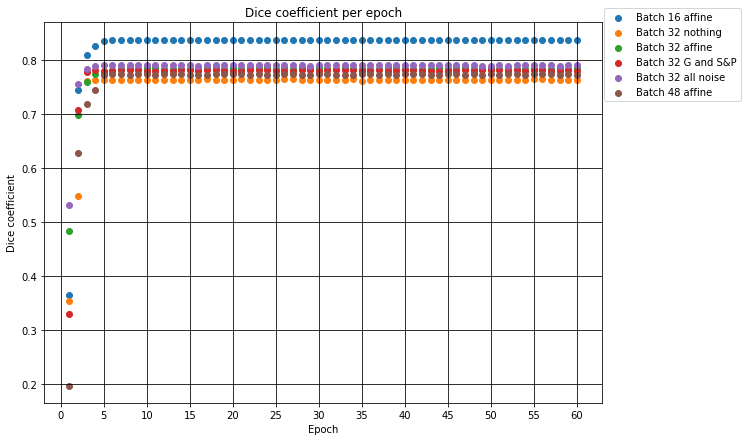

In [ ]:
# Comparison of dice coefficients

epoch_b16_nothing, dice_b16_nothing = metric_per_epoch(epoch_number_b16_nothing, dice_epoch_res_b16_nothing)
epoch_b32_nothing, dice_b32_nothing = metric_per_epoch(epoch_number_b32_nothing, dice_epoch_res_b32_nothing)
epoch_b48_nothing, dice_b48_nothing = metric_per_epoch(epoch_number_b48_nothing, dice_epoch_res_b48_nothing)
epoch_b32_affine, dice_b32_affine = metric_per_epoch(epoch_number_b32_affine, dice_epoch_res_b32_affine)
epoch_b32_g_sp, dice_b32_g_sp = metric_per_epoch(epoch_number_b32_g_sp, dice_epoch_res_b32_g_sp)
epoch_b32_allnoise, dice_b32_allnoise = metric_per_epoch(epoch_number_b32_allnoise, dice_epoch_res_b32_allnoise)

plt.figure(figsize=(10,7))
x = range(1, len(epoch_b16_nothing)+1)
x_ = range(0, len(epoch_b16_nothing)+1, 5)
plt.title('Dice coefficient per epoch')
plt.scatter(x, dice_b16_nothing, label='Batch 16 affine')
plt.scatter(x, dice_b32_nothing, label='Batch 32 nothing')
plt.scatter(x, dice_b32_affine, label='Batch 32 affine')
plt.scatter(x, dice_b32_g_sp, label='Batch 32 G and S&P')
plt.scatter(x, dice_b32_allnoise, label='Batch 32 all noise')
plt.scatter(x, dice_b48_nothing, label='Batch 48 affine')
plt.xticks(x_)
plt.xlabel('Epoch')
plt.ylabel('Dice coefficient')
plt.legend(bbox_to_anchor=(0.995, 1.05))
plt.grid(b = True, color='black')
plt.show()

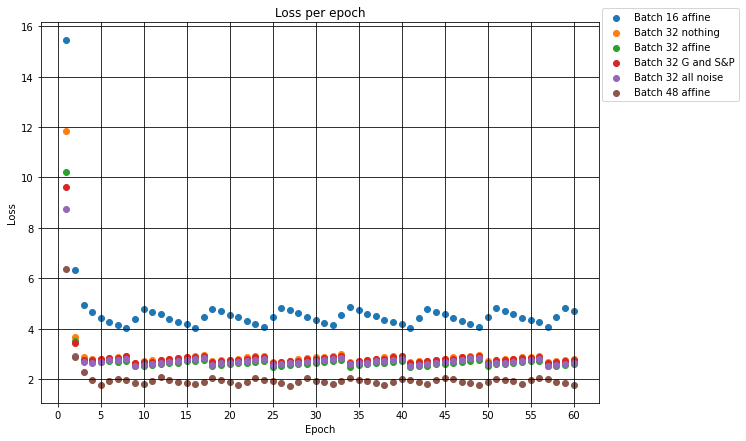

In [ ]:
# Comparison of dice coefficients

epoch_b16_nothing, loss_b16_nothing = metric_per_epoch(epoch_number_b16_nothing, loss_epoch_res_b16_nothing)
epoch_b32_nothing, loss_b32_nothing = metric_per_epoch(epoch_number_b32_nothing, loss_epoch_res_b32_nothing)
epoch_b48_nothing, loss_b48_nothing = metric_per_epoch(epoch_number_b48_nothing, loss_epoch_res_b48_nothing)
epoch_b32_affine, loss_b32_affine = metric_per_epoch(epoch_number_b32_affine, loss_epoch_res_b32_affine)
epoch_b32_g_sp, loss_b32_g_sp = metric_per_epoch(epoch_number_b32_g_sp, loss_epoch_res_b32_g_sp)
epoch_b32_allnoise, loss_b32_allnoise = metric_per_epoch(epoch_number_b32_allnoise, loss_epoch_res_b32_allnoise)

plt.figure(figsize=(10,7))
x = range(1, len(epoch_b16_nothing)+1)
x_ = range(0, len(epoch_b16_nothing)+1, 5)
plt.title('Loss per epoch')
plt.scatter(x, loss_b16_nothing, label='Batch 16 affine')
plt.scatter(x, loss_b32_nothing, label='Batch 32 nothing')
plt.scatter(x, loss_b32_affine, label='Batch 32 affine')
plt.scatter(x, loss_b32_g_sp, label='Batch 32 G and S&P')
plt.scatter(x, loss_b32_allnoise, label='Batch 32 all noise')
plt.scatter(x, loss_b48_nothing, label='Batch 48 affine')
plt.xticks(x_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.26, 1.05))
plt.grid(b = True, color='black')
plt.show()

# dHCP results Pytorch UNet

## generate 3D images

In [ ]:
pred_mask = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_UNet_DA/output_b32_CP_dHCP_30subj/'
dHCP_mask = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/dHCP_dataset/mask_3D/'
dHCP_mask_list = glob(dHCP_mask+'*.nii.gz')
dest_3D_mask = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_UNet_DA/output_b32_CP_dHCP_30subj_3D/'
count_slices = 0

ids_dHCP = [splitext(splitext(file)[0])[0] for file in listdir(pred_mask) if not file.startswith('.')]
#ids_dHCP.remove('GT')
ids_dHCP_rnd = []
count = 0

for i in range(len(ids_dHCP)):
    name = ids_dHCP[i].split('_')[0]+'_'+ids_dHCP[i].split('_')[1]
    if name not in ids_dHCP_rnd:
        ids_dHCP_rnd.append(name)
        count += 1

mask_file = dHCP_mask_list[0]
mask_gt = nib.load(mask_file).get_fdata()

print('Number of subjects: '+str(count))

for idx in ids_dHCP_rnd:
    pred_file = sorted(glob(pred_mask + idx + '_*.nii.gz'))
    print(len(pred_file))
    subject = idx.split('_')[0]
    session = idx.split('_')[1]
    dice_slice = []
    mask3D = np.zeros(mask_gt.shape)

    print('Subject: '+str(subject)+'\t Session: '+str(session))
    for i in range(len(pred_file)):
        sli_m = int(pred_file[i].split('/')[8].split('_')[2].split('.')[0])
        mask_pred = nib.load(pred_file[i]).get_fdata()
        mask3D[:,:,sli_m] = mask_pred

    mask_ = mask3D.astype(np.float32)
    mask_3D = nib.Nifti1Image(mask_, affine=None)
    nib.save(mask_3D, dest_3D_mask+str(subject)+'_'+str(session)+'.nii.gz')

Number of subjects: 30
203
Subject: CC00525XX14	 Session: 150600
203
Subject: CC00334XX13	 Session: 106100
203
Subject: CC00109XX10	 Session: 36901
203
Subject: CC00822XX14	 Session: 15710
203
Subject: CC00529AN18	 Session: 170000
203
Subject: CC00421AN09	 Session: 126000
203
Subject: CC00583XX15	 Session: 178600
203
Subject: CC00349XX20	 Session: 110300
203
Subject: CC00218AN12	 Session: 74801
203
Subject: CC00489XX20	 Session: 138800
203
Subject: CC00500XX05	 Session: 145900
203
Subject: CC00086XX13	 Session: 31500
203
Subject: CC00735XX18	 Session: 222201
203
Subject: CC00150BN02	 Session: 49100
203
Subject: CC00457XX12	 Session: 138601
203
Subject: CC00824XX16	 Session: 38310
203
Subject: CC00382XX12	 Session: 121700
203
Subject: CC00324XX11	 Session: 111200
203
Subject: CC00764AN14	 Session: 231800
203
Subject: CC00489XX20	 Session: 142900
203
Subject: CC00871XX14	 Session: 38810
203
Subject: CC00122XX07	 Session: 42000
203
Subject: CC00352XX06	 Session: 110700
203
Subject: CC0040

## dice coefficient per slice

In [ ]:
pred_CP_3D = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_UNet_DA/output_b32_CP_dHCP_30subj_3D/'
GT_dHCP_test = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/dHCP_dataset/dHCP_test_30subjects/'

ids_dHCP = [splitext(splitext(file)[0])[0] for file in listdir(GT_dHCP_test + 'CP_mask3D/') if not file.startswith('.')]
#ids_dHCP.remove('GT')
count = 0

print('Number of subjects: '+str(len(ids_dHCP)))
print(ids_dHCP)
dice_slice_pytorch = []

for idx in ids_dHCP:

    count += 1
    pred_CP_file = glob(pred_CP_3D + idx + '.nii.gz')[0]
    mask_file = glob(GT_dHCP_test + 'CP_mask3D/' + idx + '.nii.gz')[0]

    pred_CP = nib.load(pred_CP_file).get_fdata()
    mask = nib.load(mask_file).get_fdata()

    subject = idx.split('_')[0]
    session = idx.split('_')[1]
    
    mask_gt_pr = preprocess(mask, 0).squeeze()
    pred_CP_pr = preprocess(pred_CP, 0).squeeze()
    
    print('Subject: '+str(subject)+'\t Session: '+str(session))
    for i in range(len(pred_CP_pr[1,1,:])):

        dice_slice_pytorch.append([count, i, 
                           dice_coeff_pred(pred_CP_pr[:,:,i], mask_gt_pr[:,:,i])])        

Number of subjects: 30
['CC00313XX08_100000', 'CC00583XX15_178600', 'CC00489XX20_142900', 'CC00409XX13_125600', 'CC00529AN18_170000', 'CC00500XX05_145900', 'CC00272XX09_117900', 'CC00457XX12_138601', 'CC00421AN09_126000', 'CC00735XX18_222201', 'CC00489XX20_138800', 'CC00764AN14_231800', 'CC00158XX10_52200', 'CC00334XX13_106100', 'CC00871XX14_38810', 'CC00801XX09_29510', 'CC00086XX13_31500', 'CC00349XX20_110300', 'CC00352XX06_110700', 'CC00122XX07_42000', 'CC00168XX12_55700', 'CC00822XX14_15710', 'CC00824XX16_38310', 'CC00324XX11_111200', 'CC00109XX10_36901', 'CC00382XX12_121700', 'CC00719XX18_210600', 'CC00150BN02_49100', 'CC00218AN12_74801', 'CC00525XX14_150600']
Subject: CC00313XX08	 Session: 100000
Subject: CC00583XX15	 Session: 178600
Subject: CC00489XX20	 Session: 142900
Subject: CC00409XX13	 Session: 125600
Subject: CC00529AN18	 Session: 170000
Subject: CC00500XX05	 Session: 145900
Subject: CC00272XX09	 Session: 117900
Subject: CC00457XX12	 Session: 138601
Subject: CC00421AN09	 S

Subject: 1
Subject: 2
Subject: 3
Subject: 4
Subject: 5
Subject: 6
Subject: 7
Subject: 8
Subject: 9
Subject: 10
Subject: 11
Subject: 12
Subject: 13
Subject: 14
Subject: 15
Subject: 16
Subject: 17
Subject: 18
Subject: 19
Subject: 20
Subject: 21
Subject: 22
Subject: 23
Subject: 24
Subject: 25
Subject: 26
Subject: 27
Subject: 28
Subject: 29
Subject: 30


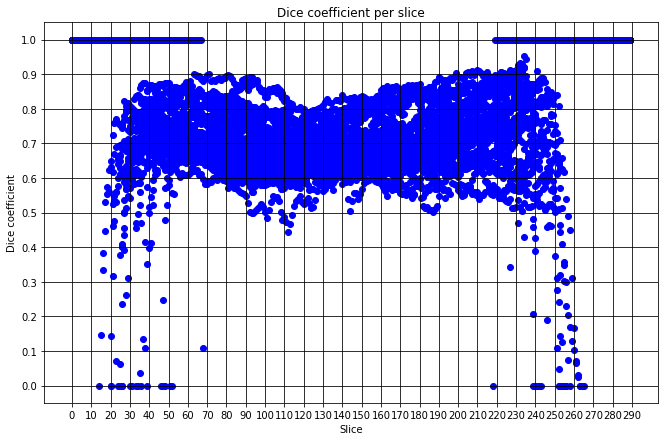

In [ ]:
subject_ = [i[0] for i in dice_slice_pytorch]
sub = np.unique(subject_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,7))

for s in range(len(sub)):
    print('Subject: '+str(sub[s]))
    dice = []
    for j in range(len(subject_)):
        if sub[s] == subject_[j]:
            dice.append([dice_slice_pytorch[j][1], dice_slice_pytorch[j][2]])

    slices_ = [i[0] for i in dice]
    slices = list(map(int, slices_))
    dice_CP = [i[1] for i in dice]

    plt.xticks(np.arange(0, np.max(slices)+10, 10))
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    plt.scatter(slices, dice_CP, color='blue', label='CP label')
    #ax.set_facecolor('gray')
    plt.title('Dice coefficient per slice')
    plt.ylabel('Dice coefficient')
    plt.xlabel('Slice')
    #plt.grid(b = True, color='white')
    plt.grid(b = True, color='black')

plt.show()

## dice coefficient 3D

In [ ]:
dHCP_imgs = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/dHCP_dataset/dHCP_test_30subjects/img3D_norm/'
dHCP_mask_CP = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/dHCP_dataset/dHCP_test_30subjects/CP_mask3D/'
pred_CP_dir = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_UNet_DA/output_b32_CP_dHCP_30subj_3D/'

ids_dHCP = [splitext(splitext(file)[0])[0] for file in listdir(pred_CP_dir) if not file.startswith('.')]
#ids_dHCP.remove('GT')
dice_coeffs_3D_pytorch = []
num = 0
print(ids_dHCP)

for idx in ids_dHCP:
    num += 1

    print(str(num)+'\t Subject: '+str(idx))

    img_file = glob(dHCP_imgs + idx + '.nii.gz')[0]
    mask_file_CP = glob(dHCP_mask_CP + idx + '.nii.gz')[0]
    pred_file_CP = glob(pred_CP_dir + idx + '.nii.gz')[0]
    
    img = nib.load(img_file).get_fdata()
    mask_CP = nib.load(mask_file_CP).get_fdata()
    pred_CP = nib.load(pred_file_CP).get_fdata()

    # dHCP image
    img_all = preprocess(img, np.nanmin(img))
    img_all_ = img_all.copy().astype('float')
    img_all_[img_all_ == 0] = np.nan

    imgx100x = np.flip(img_all_[:,100,:])
    img100xx = img_all_[100,:,:]
    imgxx100 = img_all_[:,:,100]
    
    # dHCP GT
    mask_CP_all = preprocess(mask_CP, 0)
    mask_CP_all_ = mask_CP_all.copy().astype('float')
    mask_CP_all_[mask_CP_all_ == 0] = np.nan

    mask_CPx100x = np.flip(mask_CP_all_[:,100,:])
    mask_CP100xx = mask_CP_all_[100,:,:]
    mask_CPxx100 = mask_CP_all_[:,:,100]

    # dHCP prediction
    pred_CP_all = preprocess(pred_CP, 0)
    pred_CP_all_ = pred_CP_all.copy().astype('float')
    pred_CP_all_[pred_CP_all_ == 0] = np.nan

    pred_CPx100x = np.flip(pred_CP_all_[:,100,:])
    pred_CP100xx = pred_CP_all_[100,:,:]
    pred_CPxx100 = pred_CP_all_[:,:,100]

    dice3D_CP = dice_coeff_pred(mask_CP_all, pred_CP_all)
    kernel = np.ones((3,3),np.uint8)

    dice3D_erosion = dice_coeff_pred(mask_CP_all, ndimage.binary_erosion(pred_CP_all))
    dice3D_dilation = dice_coeff_pred(mask_CP_all, ndimage.binary_dilation(pred_CP_all))
    dice3D_close = dice_coeff_pred(mask_CP_all, ndimage.binary_closing(pred_CP_all))
    dice3D_open = dice_coeff_pred(mask_CP_all, ndimage.binary_opening(pred_CP_all))
    dice3D_LCR = dice_coeff_pred(mask_CP_all, get_largest_connected_region(pred_CP_all))
    dice3D_clo_LCR = dice_coeff_pred(mask_CP_all, get_largest_connected_region(ndimage.binary_closing(pred_CP_all)))
    dice3D_LCR_clo = dice_coeff_pred(mask_CP_all, ndimage.binary_closing(get_largest_connected_region(pred_CP_all)))
    
    dice_coeffs_3D_pytorch.append([num, dice3D_CP, dice3D_erosion, dice3D_dilation, 
                           dice3D_close, dice3D_open, dice3D_LCR, dice3D_clo_LCR,
                           dice3D_LCR_clo])
    print('Dice coefficient for CP (3D): '+str(dice3D_CP))
    
    plt.subplots(1, 3, figsize=(10,6))

    plt.title('Prediction CP')
    plt.subplot(131)
    plt.imshow(imgx100x, cmap='gray')
    plt.imshow(mask_CPx100x, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_CPx100x, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(img100xx, cmap='gray')
    plt.imshow(mask_CP100xx, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_CP100xx, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(imgxx100, cmap='gray')
    plt.imshow(mask_CPxx100, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_CPxx100, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

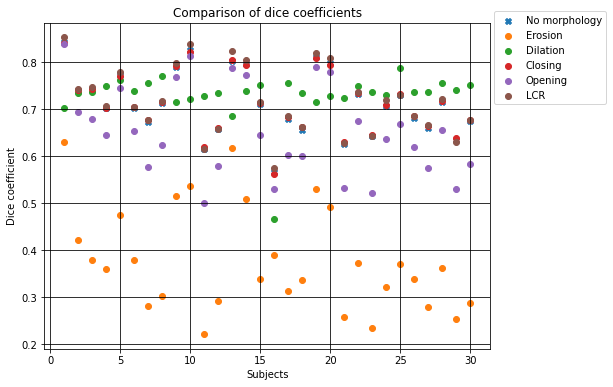

In [ ]:
subject = [i[0] for i in dice_coeffs_3D_pytorch]
dice_CP = [i[1] for i in dice_coeffs_3D_pytorch]
dice_erosion = [i[2] for i in dice_coeffs_3D_pytorch]
dice_dilation = [i[3] for i in dice_coeffs_3D_pytorch]
dice_close = [i[4] for i in dice_coeffs_3D_pytorch]
dice_open = [i[5] for i in dice_coeffs_3D_pytorch]
dice_LCR = [i[6] for i in dice_coeffs_3D_pytorch]
dice_clo_LCR = [i[7] for i in dice_coeffs_3D_pytorch]
dice_LCR_clo = [i[8] for i in dice_coeffs_3D_pytorch]

plt.subplots(figsize=(8,6))
x = range(1,len(subject)+1)
plt.title('Comparison of dice coefficients')
plt.scatter(x, dice_CP, label='No morphology', marker='X')
plt.scatter(x, dice_erosion, label='Erosion')
plt.scatter(x, dice_dilation, label='Dilation')
plt.scatter(x, dice_close, label='Closing')
plt.scatter(x, dice_open, label='Opening')
plt.scatter(x, dice_LCR, label='LCR')
#plt.scatter(x, dice_clo_LCR, label='Closing + LCR')
#plt.scatter(x, dice_LCR_clo, label='LCR + Closing', marker='^')
plt.xticks(np.arange(0, np.max(subject)+5, 5))
plt.xlabel('Subjects')
plt.ylabel('Dice coefficient')
plt.legend(bbox_to_anchor=(1.27, 1.05))
plt.grid(b = True, color='black')
plt.show()

# fetus results Pytorch UNet

In [ ]:
pred_mask = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_UNet_DA/output_b32_CP_fetus_2D/'
mask_path = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/fetus_dataset/img_fetus_norm_3D/'
mask_list = glob(mask_path+'*.nii.gz')
dest_3D_mask = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_UNet_DA/output_b32_CP_fetus_3D/'
count_slices = 0

ids_fetus = [splitext(splitext(file)[0])[0] for file in listdir(pred_mask) if not file.startswith('.')]
#ids_dHCP.remove('GT')
ids_fetus_rnd = []
count = 0
print(ids_fetus)

for i in range(len(ids_fetus)):
    name = ids_fetus[i].split('_')[0]+'_'+ids_fetus[i].split('_')[1]
    if name not in ids_fetus_rnd:
        ids_fetus_rnd.append(name)
        count += 1

mask_file = mask_list[0]
mask_gt = nib.load(mask_file).get_fdata()

print('Number of subjects: '+str(count))

for idx in ids_fetus_rnd:
    pred_file = sorted(glob(pred_mask + idx + '_*.nii.gz'))
    print(len(pred_file))
    subject = idx.split('_')[0]
    session = idx.split('_')[1]
    dice_slice = []
    mask3D = np.zeros(mask_gt.shape)
    #print(mask3D.shape)

    print('Subject: '+str(subject)+'\t MRI date: '+str(session))
    for i in range(len(pred_file)):
        #print(pred_file[i].split('/')[8].split('_')[2].split('.')[0])
        sli_m = int(pred_file[i].split('/')[8].split('_')[2].split('.')[0])
        mask_pred = nib.load(pred_file[i]).get_fdata()
        mask3D[:,:,sli_m] = mask_pred

    mask_ = mask3D.astype(np.float32)
    mask_3D = nib.Nifti1Image(mask_, affine=None)
    nib.save(mask_3D, dest_3D_mask+str(subject)+'_'+str(session)+'.nii.gz')

['marsFet021_32_223', 'marsFet059_35_200', 'marsFet005_30_188', 'marsFet042_30_201', 'marsFet011_36_32', 'marsFet042_30_51', 'marsFet047_28_130', 'marsFet021_32_74', 'marsFet021_32_194', 'marsFet053_29_164', 'marsFet044_33_235', 'marsFet021_32_17', 'marsFet253_28_103', 'marsFet001_33_111', 'marsFet047_28_153', 'marsFet011_36_51', 'marsFet039_34_72', 'marsFet053_29_107', 'marsFet036_34_148', 'marsFet029_32_204', 'marsFet043_29_77', 'marsFet004_33_242', 'marsFet039_34_126', 'marsFet020_30_204', 'marsFet020_30_41', 'marsFet016_33_6', 'marsFet001_33_75', 'marsFet011_36_144', 'marsFet009_32_172', 'marsFet260_29_34', 'marsFet235_33_237', 'marsFet036_34_135', 'marsFet235_33_180', 'marsFet036_34_61', 'marsFet005_30_221', 'marsFet005_30_196', 'marsFet053_29_9', 'marsFet059_35_57', 'marsFet027_28_186', 'marsFet005_30_16', 'marsFet045_30_182', 'marsFet045_30_51', 'marsFet027_28_231', 'marsFet004_33_188', 'marsFet043_29_133', 'marsFet007_29_62', 'marsFet020_30_4', 'marsFet004_33_91', 'marsFet007_2

# dHCP results Dou UNet

## dice coefficient per slice

In [ ]:
pred_CP_3D = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_2DFetalCPSeg/NoDeepSup/dHCP_30subj_3D/'
GT_dHCP_test = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/dHCP_dataset/dHCP_test_30subjects/'

ids_dHCP = [splitext(splitext(file)[0])[0] for file in listdir(GT_dHCP_test + 'CP_mask3D/') if not file.startswith('.')]
#ids_dHCP.remove('GT')
count = 0

print('Number of subjects: '+str(len(ids_dHCP)))
print(ids_dHCP)
dice_slice_Dou = []

for idx in ids_dHCP:

    count += 1
    pred_CP_file = glob(pred_CP_3D + idx + '.nii.gz')[0]
    mask_file = glob(GT_dHCP_test + 'CP_mask3D/' + idx + '.nii.gz')[0]

    pred_CP = nib.load(pred_CP_file).get_fdata()
    mask = nib.load(mask_file).get_fdata()

    subject = idx.split('_')[0]
    session = idx.split('_')[1]
    
    mask_gt_pr = preprocess(mask, 0).squeeze()
    pred_CP_pr = preprocess(pred_CP, 0).squeeze()
    
    print('Subject: '+str(subject)+'\t Session: '+str(session))
    for i in range(len(pred_CP_pr[1,1,:])):

        dice_slice_Dou.append([count, i, 
                           dice_coeff_pred(pred_CP_pr[:,:,i], mask_gt_pr[:,:,i])])        

Number of subjects: 30
['CC00313XX08_100000', 'CC00583XX15_178600', 'CC00489XX20_142900', 'CC00409XX13_125600', 'CC00529AN18_170000', 'CC00500XX05_145900', 'CC00272XX09_117900', 'CC00457XX12_138601', 'CC00421AN09_126000', 'CC00735XX18_222201', 'CC00489XX20_138800', 'CC00764AN14_231800', 'CC00158XX10_52200', 'CC00334XX13_106100', 'CC00871XX14_38810', 'CC00801XX09_29510', 'CC00086XX13_31500', 'CC00349XX20_110300', 'CC00352XX06_110700', 'CC00122XX07_42000', 'CC00168XX12_55700', 'CC00822XX14_15710', 'CC00824XX16_38310', 'CC00324XX11_111200', 'CC00109XX10_36901', 'CC00382XX12_121700', 'CC00719XX18_210600', 'CC00150BN02_49100', 'CC00218AN12_74801', 'CC00525XX14_150600']
Subject: CC00313XX08	 Session: 100000
Subject: CC00583XX15	 Session: 178600
Subject: CC00489XX20	 Session: 142900
Subject: CC00409XX13	 Session: 125600
Subject: CC00529AN18	 Session: 170000
Subject: CC00500XX05	 Session: 145900
Subject: CC00272XX09	 Session: 117900
Subject: CC00457XX12	 Session: 138601
Subject: CC00421AN09	 S

## dice coefficient 3D

In [ ]:
dHCP_imgs = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/dHCP_dataset/dHCP_test_30subjects/img3D_norm/'
dHCP_mask_CP = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/dHCP_dataset/dHCP_test_30subjects/CP_mask3D/'
pred_CP_dir = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_2DFetalCPSeg/NoDeepSup/dHCP_30subj_3D/'

ids_dHCP = [splitext(splitext(file)[0])[0] for file in listdir(pred_CP_dir) if not file.startswith('.')]
#ids_dHCP.remove('GT')
dice_coeffs_3D_Dou = []
num = 0
print(ids_dHCP)

for idx in ids_dHCP:
    num += 1

    print(str(num)+'\t Subject: '+str(idx))

    img_file = glob(dHCP_imgs + idx + '.nii.gz')[0]
    mask_file_CP = glob(dHCP_mask_CP + idx + '.nii.gz')[0]
    pred_file_CP = glob(pred_CP_dir + idx + '.nii.gz')[0]
    
    img = nib.load(img_file).get_fdata()
    mask_CP = nib.load(mask_file_CP).get_fdata()
    pred_CP = nib.load(pred_file_CP).get_fdata()

    # dHCP image
    img_all = preprocess(img, np.nanmin(img))
    img_all_ = img_all.copy().astype('float')
    img_all_[img_all_ == 0] = np.nan

    imgx100x = np.flip(img_all_[:,100,:])
    img100xx = img_all_[100,:,:]
    imgxx100 = img_all_[:,:,100]
    
    # dHCP GT
    mask_CP_all = preprocess(mask_CP, 0)
    mask_CP_all_ = mask_CP_all.copy().astype('float')
    mask_CP_all_[mask_CP_all_ == 0] = np.nan

    mask_CPx100x = np.flip(mask_CP_all_[:,100,:])
    mask_CP100xx = mask_CP_all_[100,:,:]
    mask_CPxx100 = mask_CP_all_[:,:,100]

    # dHCP prediction
    pred_CP_all = preprocess(pred_CP, 0)
    pred_CP_all_ = pred_CP_all.copy().astype('float')
    pred_CP_all_[pred_CP_all_ == 0] = np.nan

    pred_CPx100x = np.flip(pred_CP_all_[:,100,:])
    pred_CP100xx = pred_CP_all_[100,:,:]
    pred_CPxx100 = pred_CP_all_[:,:,100]

    dice3D_CP = dice_coeff_pred(mask_CP_all, pred_CP_all)
    kernel = np.ones((3,3),np.uint8)

    dice3D_erosion = dice_coeff_pred(mask_CP_all, ndimage.binary_erosion(pred_CP_all))
    dice3D_dilation = dice_coeff_pred(mask_CP_all, ndimage.binary_dilation(pred_CP_all))
    dice3D_close = dice_coeff_pred(mask_CP_all, ndimage.binary_closing(pred_CP_all))
    dice3D_open = dice_coeff_pred(mask_CP_all, ndimage.binary_opening(pred_CP_all))
    dice3D_LCR = dice_coeff_pred(mask_CP_all, get_largest_connected_region(pred_CP_all))
    dice3D_clo_LCR = dice_coeff_pred(mask_CP_all, get_largest_connected_region(ndimage.binary_closing(pred_CP_all)))
    dice3D_LCR_clo = dice_coeff_pred(mask_CP_all, ndimage.binary_closing(get_largest_connected_region(pred_CP_all)))
    
    dice_coeffs_3D_Dou.append([num, dice3D_CP, dice3D_erosion, dice3D_dilation, 
                           dice3D_close, dice3D_open, dice3D_LCR, dice3D_clo_LCR,
                           dice3D_LCR_clo])
    print('Dice coefficient for CP (3D): '+str(dice3D_CP))
    
    plt.subplots(1, 3, figsize=(10,6))

    plt.title('Prediction CP')
    plt.subplot(131)
    plt.imshow(imgx100x, cmap='gray')
    plt.imshow(mask_CPx100x, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_CPx100x, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(img100xx, cmap='gray')
    plt.imshow(mask_CP100xx, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_CP100xx, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(imgxx100, cmap='gray')
    plt.imshow(mask_CPxx100, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_CPxx100, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# fetus results Dou UNet

In [ ]:
pred_mask = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_2DFetalCPSeg/NoDeepSup/fetus_test/'
mask_path = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/fetus_dataset/img_fetus_norm_3D/'
mask_list = glob(mask_path+'*.nii.gz')
dest_3D_mask = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_2DFetalCPSeg/NoDeepSup/fetus_test_3D/'
count_slices = 0

ids_fetus = [splitext(splitext(file)[0])[0] for file in listdir(pred_mask) if not file.startswith('.')]
#ids_dHCP.remove('GT')
ids_fetus_rnd = []
count = 0
print(ids_fetus)

for i in range(len(ids_fetus)):
    name = ids_fetus[i].split('_')[0]+'_'+ids_fetus[i].split('_')[1]
    if name not in ids_fetus_rnd:
        ids_fetus_rnd.append(name)
        count += 1

mask_file = mask_list[0]
mask_gt = nib.load(mask_file).get_fdata()

print('Number of subjects: '+str(count))

for idx in ids_fetus_rnd:
    pred_file = sorted(glob(pred_mask + idx + '_*.nii.gz'))
    print(len(pred_file))
    subject = idx.split('_')[0]
    session = idx.split('_')[1]
    dice_slice = []
    mask3D = np.zeros(mask_gt.shape)
    #print(mask3D.shape)

    print('Subject: '+str(subject)+'\t MRI date: '+str(session))
    for i in range(len(pred_file)):
        #print(pred_file[i].split('/')[9].split('_')[2].split('.')[0])
        sli_m = int(pred_file[i].split('/')[9].split('_')[2].split('.')[0])
        mask_pred = nib.load(pred_file[i]).get_fdata()
        mask3D[:,:,sli_m] = mask_pred

    mask_ = mask3D.astype(np.float32)
    mask_3D = nib.Nifti1Image(mask_, affine=None)
    nib.save(mask_3D, dest_3D_mask+str(subject)+'_'+str(session)+'.nii.gz')

['marsFet039_34_145', 'marsFet027_28_198', 'marsFet043_29_14', 'marsFet039_34_11', 'marsFet027_28_63', 'marsFet004_33_196', 'marsFet004_33_221', 'marsFet235_33_95', 'marsFet260_29_57', 'marsFet007_29_1', 'marsFet260_29_215', 'marsFet044_33_182', 'marsFet020_30_22', 'marsFet059_35_3', 'marsFet235_33_229', 'marsFet021_32_223', 'marsFet059_35_49', 'marsFet001_33_172', 'marsFet253_28_160', 'marsFet040_36_213', 'marsFet016_33_111', 'marsFet059_35_200', 'marsFet011_36_32', 'marsFet053_29_164', 'marsFet005_30_188', 'marsFet042_30_201', 'marsFet047_28_130', 'marsFet021_32_194', 'marsFet021_32_74', 'marsFet042_30_51', 'marsFet044_33_235', 'marsFet235_33_246', 'marsFet235_33_87', 'marsFet260_29_45', 'marsFet059_35_26', 'marsFet260_29_207', 'marsFet004_33_184', 'marsFet020_30_30', 'marsFet045_30_239', 'marsFet020_30_8', 'marsFet011_36_135', 'marsFet004_33_233', 'marsFet021_32_186', 'marsFet027_28_71', 'marsFet011_36_20', 'marsFet042_30_213', 'marsFet036_34_139', 'marsFet039_34_157', 'marsFet021_3

# Comparison

## dice coefficient per slice

Subject: 1
Subject: 2
Subject: 3
Subject: 4
Subject: 5
Subject: 6
Subject: 7
Subject: 8
Subject: 9
Subject: 10
Subject: 11
Subject: 12
Subject: 13
Subject: 14
Subject: 15
Subject: 16
Subject: 17
Subject: 18
Subject: 19
Subject: 20
Subject: 21
Subject: 22
Subject: 23
Subject: 24
Subject: 25
Subject: 26
Subject: 27
Subject: 28
Subject: 29
Subject: 30


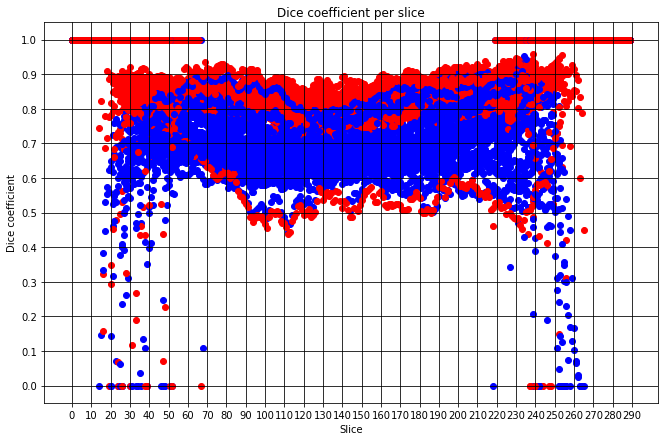

In [ ]:
subject_pytorch = [i[0] for i in dice_slice_pytorch]
subject_dou = [i[0] for i in dice_slice_Dou]
sub = np.unique(subject_dou)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,7))

for s in range(len(sub)):
    print('Subject: '+str(sub[s]))
    dice_pytorch = []
    dice_dou = []
    for j in range(len(subject_dou)):
        if sub[s] == subject_pytorch[j]:
            dice_pytorch.append([dice_slice_pytorch[j][1], dice_slice_pytorch[j][2]])
            dice_dou.append([dice_slice_Dou[j][1], dice_slice_Dou[j][2]])

    slices_pytorch = [i[0] for i in dice_pytorch]
    slices_pytorch = list(map(int, slices_pytorch))
    dice_CP_pytorch = [i[1] for i in dice_pytorch]
    
    slices_dou = [i[0] for i in dice_dou]
    slices_dou = list(map(int, slices_dou))
    dice_CP_dou = [i[1] for i in dice_dou]

    plt.xticks(np.arange(0, np.max(slices_dou)+10, 10))
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    plt.scatter(slices_dou, dice_CP_pytorch, color='blue', label='Pytorch UNet')
    plt.scatter(slices_dou, dice_CP_dou, color='red', label='FetalCPSeg UNet')
    #ax.set_facecolor('gray')
    plt.title('Dice coefficient per slice')
    plt.ylabel('Dice coefficient')
    plt.xlabel('Slice')
    #plt.grid(b = True, color='white')
    plt.grid(b = True, color='black')

plt.show()

## dice coefficient 3D

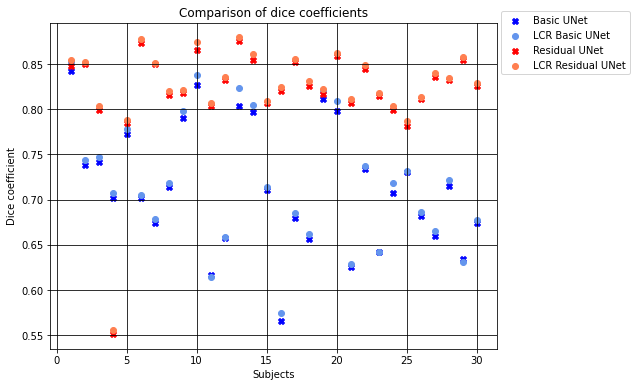

In [ ]:
subject = [i[0] for i in dice_coeffs_3D_pytorch]
dice_CP = [i[1] for i in dice_coeffs_3D_pytorch]
dice_erosion = [i[2] for i in dice_coeffs_3D_pytorch]
dice_dilation = [i[3] for i in dice_coeffs_3D_pytorch]
dice_close = [i[4] for i in dice_coeffs_3D_pytorch]
dice_open = [i[5] for i in dice_coeffs_3D_pytorch]
dice_LCR = [i[6] for i in dice_coeffs_3D_pytorch]
dice_clo_LCR = [i[7] for i in dice_coeffs_3D_pytorch]
dice_LCR_clo = [i[8] for i in dice_coeffs_3D_pytorch]

subject_Dou = [i[0] for i in dice_coeffs_3D_Dou]
dice_CP_Dou = [i[1] for i in dice_coeffs_3D_Dou]
dice_erosion_Dou = [i[2] for i in dice_coeffs_3D_Dou]
dice_dilation_Dou = [i[3] for i in dice_coeffs_3D_Dou]
dice_close_Dou = [i[4] for i in dice_coeffs_3D_Dou]
dice_open_Dou = [i[5] for i in dice_coeffs_3D_Dou]
dice_LCR_Dou = [i[6] for i in dice_coeffs_3D_Dou]
dice_clo_LCR_Dou = [i[7] for i in dice_coeffs_3D_Dou]
dice_LCR_clo_Dou = [i[8] for i in dice_coeffs_3D_Dou]

plt.subplots(figsize=(8,6))
x = range(1,len(subject_Dou)+1)
plt.title('Comparison of dice coefficients')
plt.scatter(x, dice_CP, label='Basic UNet', marker='X', color='blue')
#plt.scatter(x, dice_erosion, label='Erosion')
#plt.scatter(x, dice_dilation, label='Dilation')
#plt.scatter(x, dice_close, label='Closing')
#plt.scatter(x, dice_open, label='Opening')
plt.scatter(x, dice_LCR, label='LCR Basic UNet', color='cornflowerblue')
#plt.scatter(x, dice_LCR_clo, label='Opening')
#plt.scatter(x, dice_clo_LCR, label='LCR ')
plt.scatter(x, dice_CP_Dou, label='Residual UNet', marker='X', color='red') #FetalCPSeg
#plt.scatter(x, dice_erosion_Dou, label='Erosion')
#plt.scatter(x, dice_dilation_Dou, label='Dilation')
#plt.scatter(x, dice_close_Dou, label='Closing')
#plt.scatter(x, dice_open_Dou, label='Opening')
plt.scatter(x, dice_LCR_Dou, label='LCR Residual UNet', color='coral') # FetalCPSeg
#plt.scatter(x, dice_clo_LCR_Dou, label='Closing + LCR')
#plt.scatter(x, dice_LCR_clo_Dou, label='LCR + Closing')
plt.xticks(np.arange(0, np.max(subject_Dou)+5, 5))
plt.xlabel('Subjects')
plt.ylabel('Dice coefficient')
plt.legend(bbox_to_anchor=(1.31, 1.05))
plt.grid(b = True, color='black')
plt.show()

## plot both dHCP

['CC00764AN14_231800', 'CC00801XX09_29510', 'CC00822XX14_15710', 'CC00824XX16_38310', 'CC00871XX14_38810', 'CC00525XX14_150600', 'CC00529AN18_170000', 'CC00583XX15_178600', 'CC00719XX18_210600', 'CC00735XX18_222201', 'CC00421AN09_126000', 'CC00457XX12_138601', 'CC00489XX20_138800', 'CC00489XX20_142900', 'CC00500XX05_145900', 'CC00334XX13_106100', 'CC00349XX20_110300', 'CC00352XX06_110700', 'CC00382XX12_121700', 'CC00409XX13_125600', 'CC00168XX12_55700', 'CC00218AN12_74801', 'CC00272XX09_117900', 'CC00313XX08_100000', 'CC00324XX11_111200', 'CC00086XX13_31500', 'CC00109XX10_36901', 'CC00122XX07_42000', 'CC00150BN02_49100', 'CC00158XX10_52200']
1	 Subject: CC00764AN14_231800


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


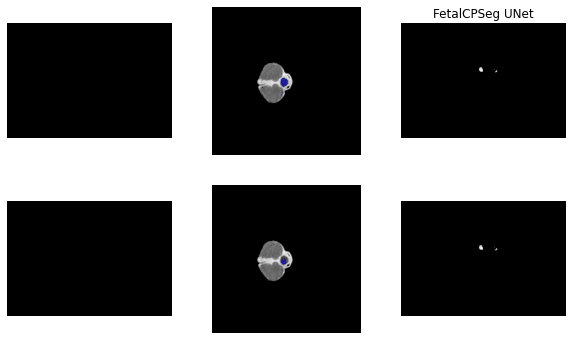

2	 Subject: CC00801XX09_29510


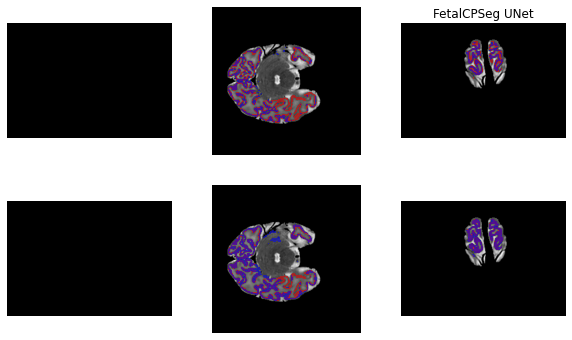

3	 Subject: CC00822XX14_15710


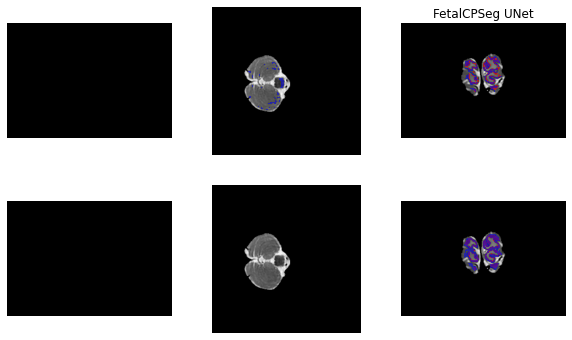

4	 Subject: CC00824XX16_38310


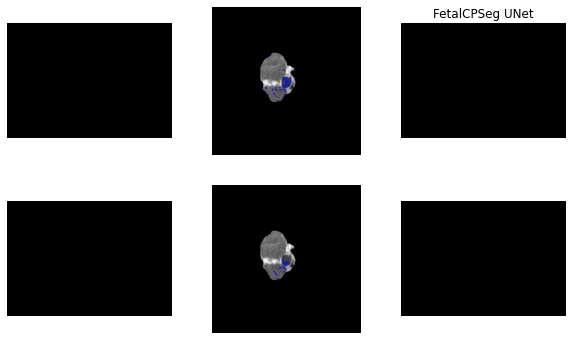

5	 Subject: CC00871XX14_38810


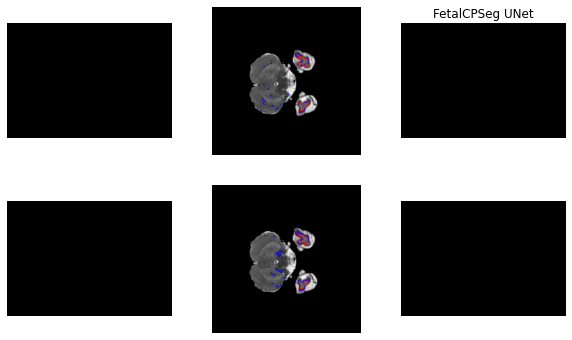

6	 Subject: CC00525XX14_150600


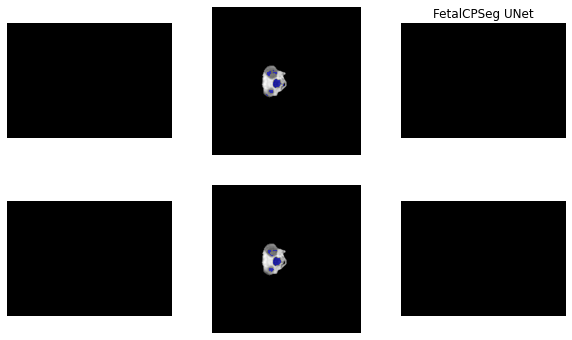

7	 Subject: CC00529AN18_170000


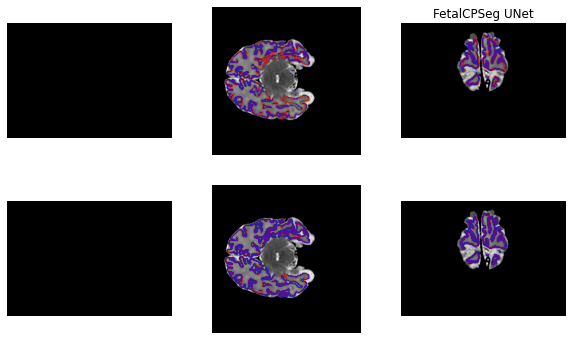

8	 Subject: CC00583XX15_178600


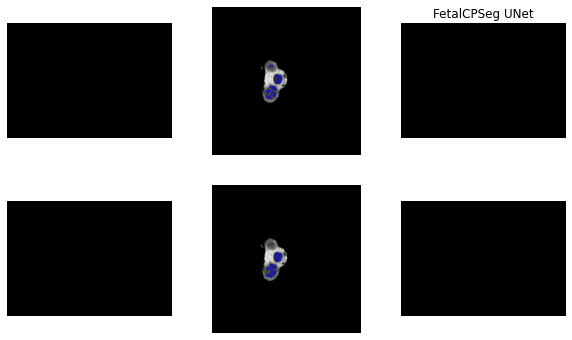

9	 Subject: CC00719XX18_210600


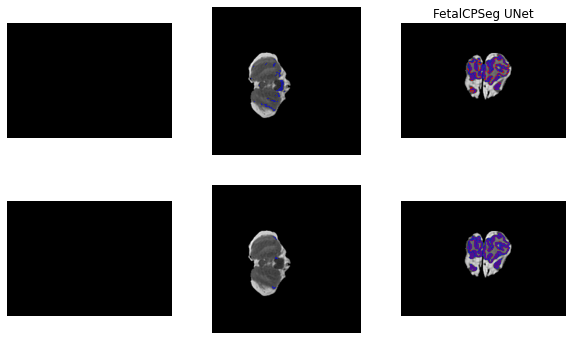

10	 Subject: CC00735XX18_222201


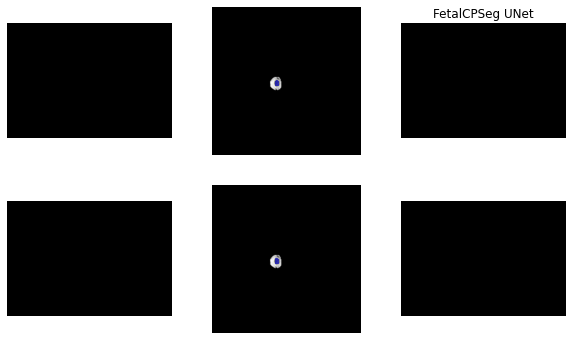

11	 Subject: CC00421AN09_126000


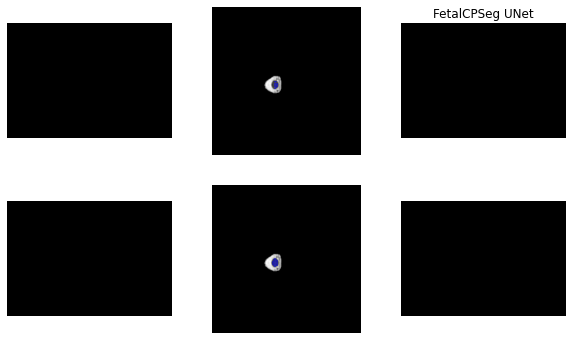

12	 Subject: CC00457XX12_138601


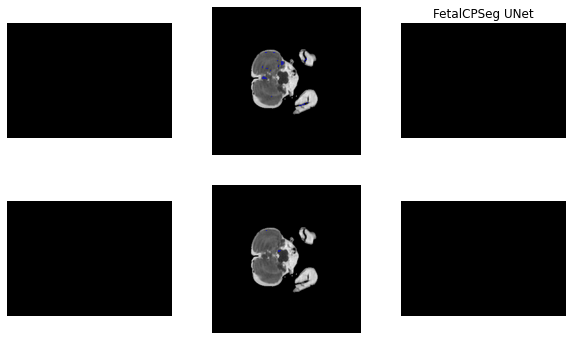

13	 Subject: CC00489XX20_138800


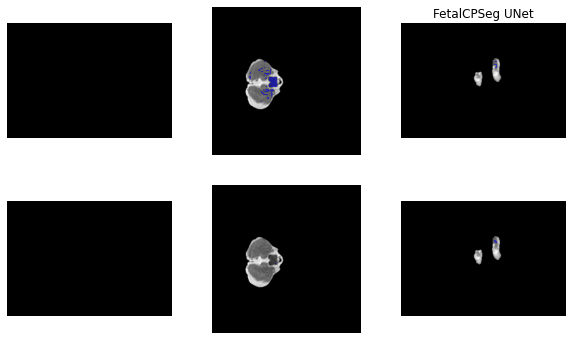

14	 Subject: CC00489XX20_142900


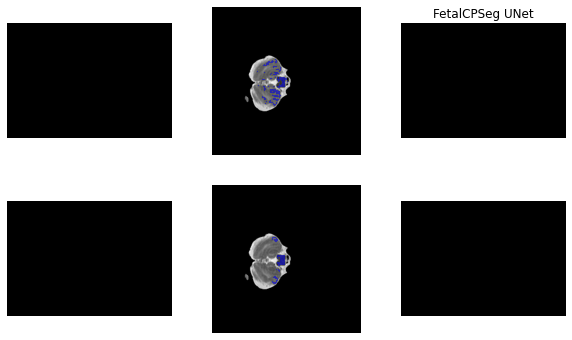

15	 Subject: CC00500XX05_145900


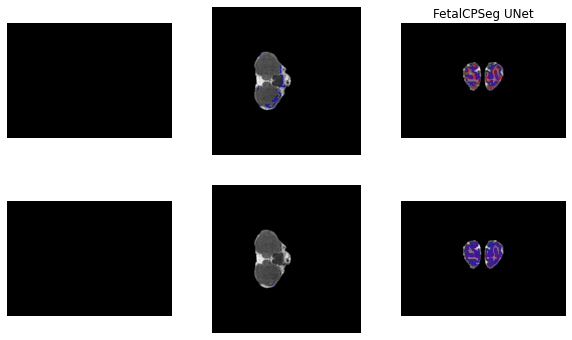

16	 Subject: CC00334XX13_106100


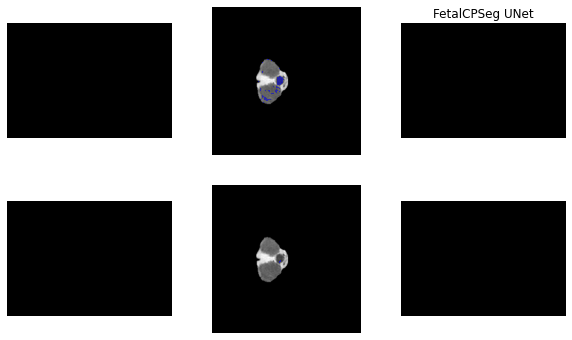

17	 Subject: CC00349XX20_110300


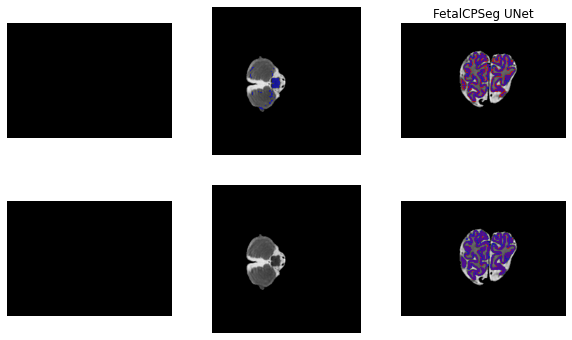

18	 Subject: CC00352XX06_110700


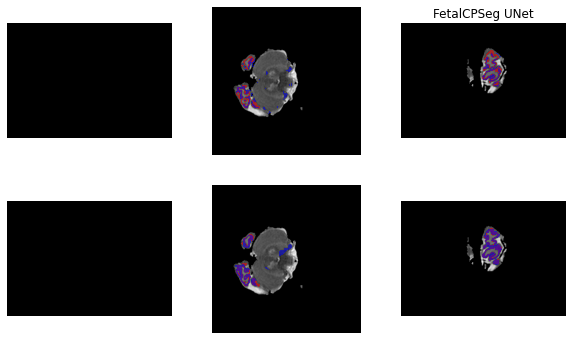

19	 Subject: CC00382XX12_121700


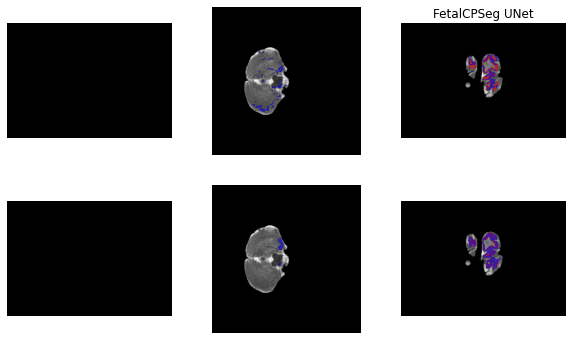

20	 Subject: CC00409XX13_125600


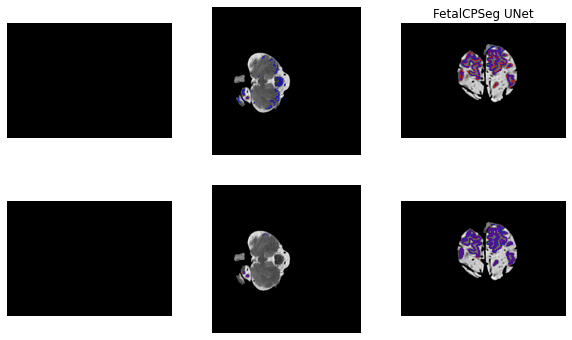

21	 Subject: CC00168XX12_55700


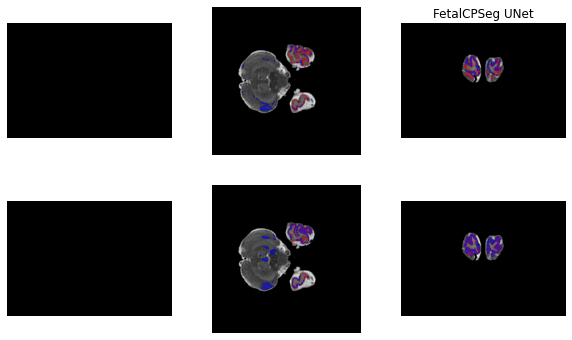

22	 Subject: CC00218AN12_74801


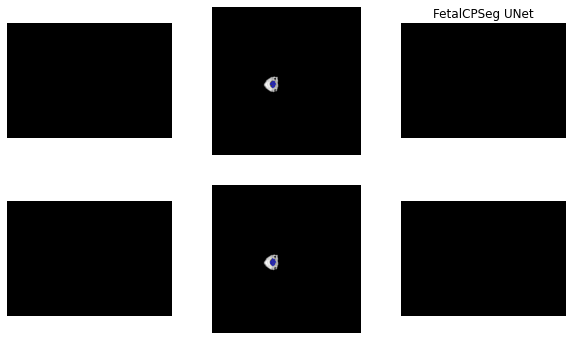

23	 Subject: CC00272XX09_117900


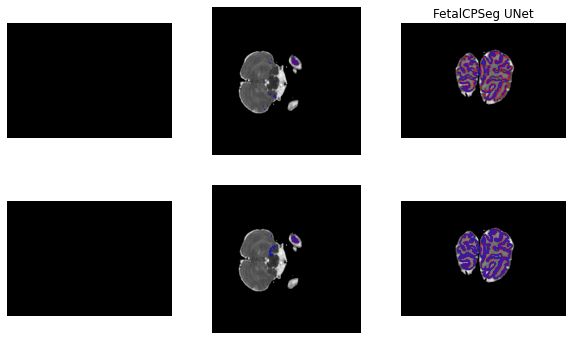

24	 Subject: CC00313XX08_100000


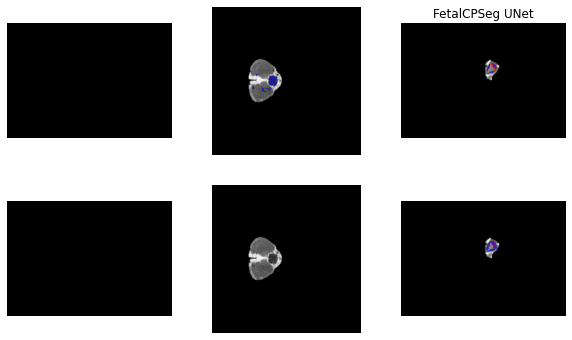

25	 Subject: CC00324XX11_111200


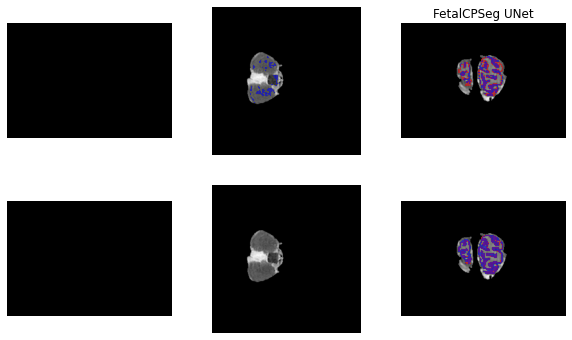

26	 Subject: CC00086XX13_31500


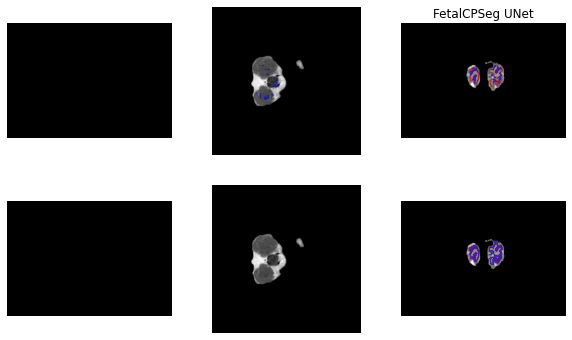

27	 Subject: CC00109XX10_36901


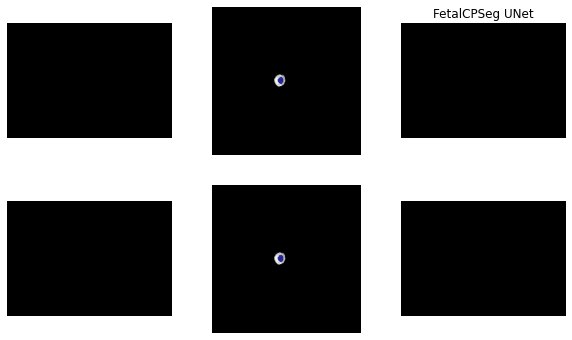

28	 Subject: CC00122XX07_42000


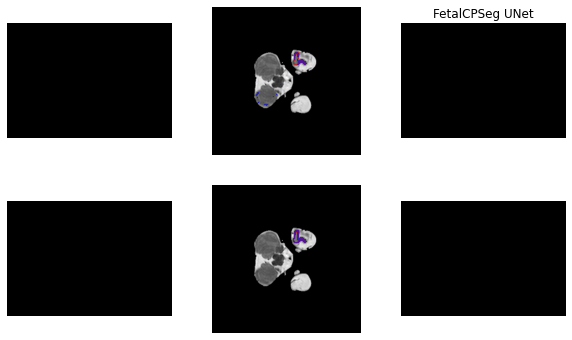

29	 Subject: CC00150BN02_49100


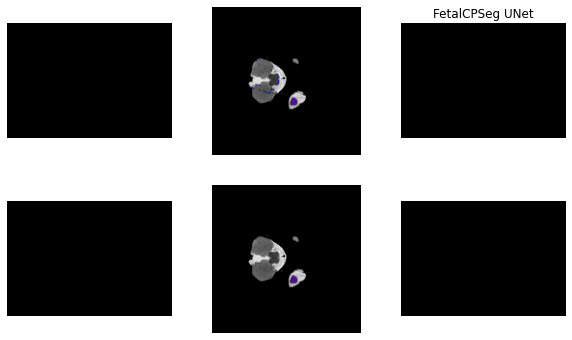

30	 Subject: CC00158XX10_52200


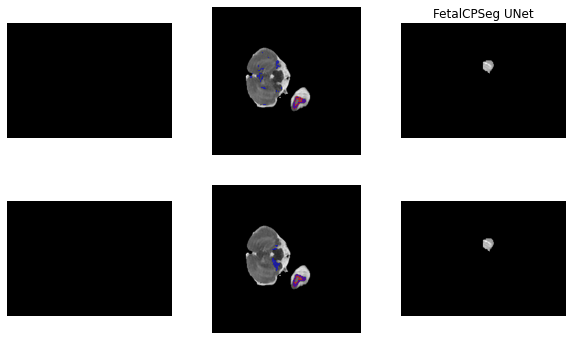

In [ ]:
dHCP_imgs = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/dHCP_dataset/dHCP_test_30subjects/img3D_norm/'
dHCP_mask_CP = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/dHCP_dataset/dHCP_test_30subjects/CP_mask3D/'
pred_pytorch_dir = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_UNet_DA/output_b32_CP_dHCP_30subj_3D/'
pred_fetalcpseg_dir = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_2DFetalCPSeg/NoDeepSup/dHCP_30subj_3D/'

ids_dHCP = [splitext(splitext(file)[0])[0] for file in listdir(pred_fetalcpseg_dir) if not file.startswith('.')]
#ids_dHCP.remove('GT')
dice_coeffs_3D_Dou = []
num = 0
print(ids_dHCP)

for idx in ids_dHCP:
    num += 1

    print(str(num)+'\t Subject: '+str(idx))

    img_file = glob(dHCP_imgs + idx + '.nii.gz')[0]
    mask_file_CP = glob(dHCP_mask_CP + idx + '.nii.gz')[0]
    pred_file_pytorch = glob(pred_pytorch_dir + idx + '.nii.gz')[0]
    pred_file_fetalcpseg = glob(pred_fetalcpseg_dir + idx + '.nii.gz')[0]
    
    img = nib.load(img_file).get_fdata()
    mask_CP = nib.load(mask_file_CP).get_fdata()
    pred_pytorch = nib.load(pred_file_pytorch).get_fdata()
    pred_fetalcpseg = nib.load(pred_file_fetalcpseg).get_fdata()

    # dHCP image
    img_all = preprocess(img, np.nanmin(img))
    img_all_ = img_all.copy().astype('float')
    img_all_[img_all_ == 0] = np.nan

    imgx100x = np.flip(img_all_[:,30,:])
    img100xx = img_all_[30,:,:]
    imgxx100 = img_all_[:,:,30]
    
    # dHCP GT
    mask_CP_all = preprocess(mask_CP, 0)
    mask_CP_all_ = mask_CP_all.copy().astype('float')
    mask_CP_all_[mask_CP_all_ == 0] = np.nan

    mask_CPx100x = np.flip(mask_CP_all_[:,30,:])
    mask_CP100xx = mask_CP_all_[30,:,:]
    mask_CPxx100 = mask_CP_all_[:,:,30]

    # Pytorch UNet
    pred_pytorch_all = preprocess(pred_pytorch, 0)
    pred_pytorch_all_ = pred_pytorch_all.copy().astype('float')
    pred_pytorch_all_[pred_pytorch_all_ == 0] = np.nan

    pred_pytorchx100x = np.flip(pred_pytorch_all_[:,30,:])
    pred_pytorch100xx = pred_pytorch_all_[30,:,:]
    pred_pytorchxx100 = pred_pytorch_all_[:,:,30]

    # FetalCPSeg
    pred_fetalcpseg_all = preprocess(pred_fetalcpseg, 0)
    pred_fetalcpseg_all_ = pred_fetalcpseg_all.copy().astype('float')
    pred_fetalcpseg_all_[pred_fetalcpseg_all_ == 0] = np.nan

    pred_fetalcpsegx100x = np.flip(pred_fetalcpseg_all_[:,30,:])
    pred_fetalcpseg100xx = pred_fetalcpseg_all_[30,:,:]
    pred_fetalcpsegxx100 = pred_fetalcpseg_all_[:,:,30]
  
    plt.subplots(2, 3, figsize=(10,6))

    plt.title('Pytorch UNet')
    plt.subplot(231)
    plt.imshow(imgx100x, cmap='gray')
    plt.imshow(mask_CPx100x, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_pytorchx100x, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(232)
    plt.imshow(img100xx, cmap='gray')
    plt.imshow(mask_CP100xx, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_pytorch100xx, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(233)
    plt.imshow(imgxx100, cmap='gray')
    plt.imshow(mask_CPxx100, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_pytorchxx100, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')

    plt.title('FetalCPSeg UNet')
    plt.subplot(234)
    plt.imshow(imgx100x, cmap='gray')
    plt.imshow(mask_CPx100x, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_fetalcpsegx100x, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(235)
    plt.imshow(img100xx, cmap='gray')
    plt.imshow(mask_CP100xx, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_fetalcpseg100xx, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(236)
    plt.imshow(imgxx100, cmap='gray')
    plt.imshow(mask_CPxx100, alpha=0.5, cmap='autumn', interpolation='none')
    plt.imshow(pred_fetalcpsegxx100, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')

    plt.show()

## plot both fetus

['marsFet021_32', 'marsFet059_35', 'marsFet005_30', 'marsFet042_30', 'marsFet011_36', 'marsFet047_28', 'marsFet053_29', 'marsFet044_33', 'marsFet253_28', 'marsFet001_33', 'marsFet039_34', 'marsFet036_34', 'marsFet029_32', 'marsFet043_29', 'marsFet004_33', 'marsFet020_30', 'marsFet016_33', 'marsFet009_32', 'marsFet260_29', 'marsFet235_33', 'marsFet027_28', 'marsFet045_30', 'marsFet007_29', 'marsFet019_34', 'marsFet040_36', 'marsFet092_28', 'marsFet049_31']
1	 Subject: marsFet021_32


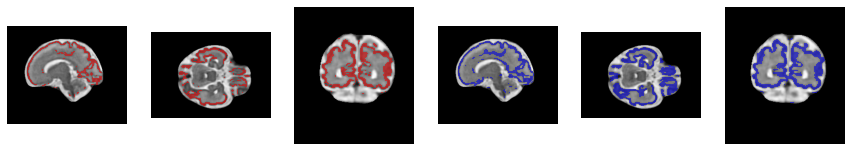

2	 Subject: marsFet059_35


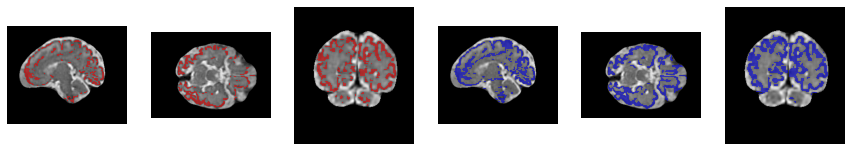

3	 Subject: marsFet005_30


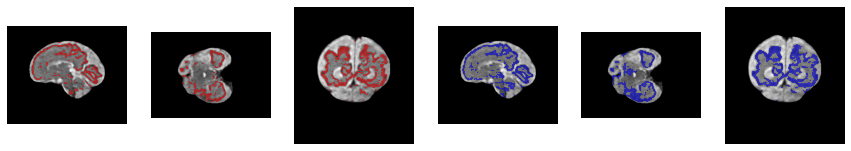

4	 Subject: marsFet042_30


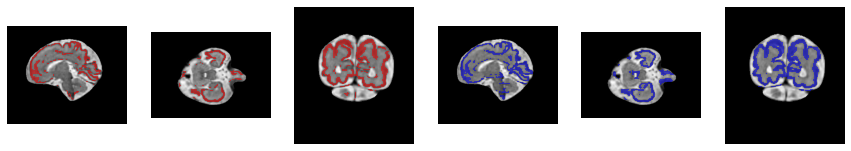

5	 Subject: marsFet011_36


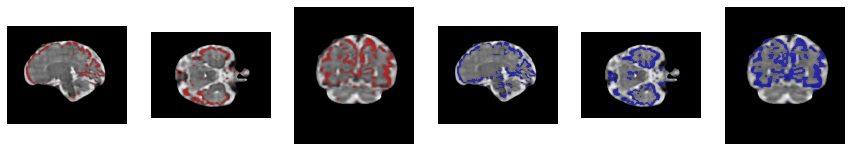

6	 Subject: marsFet047_28


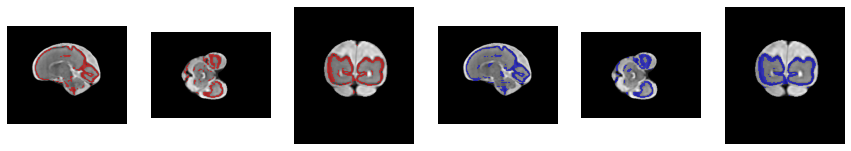

7	 Subject: marsFet053_29


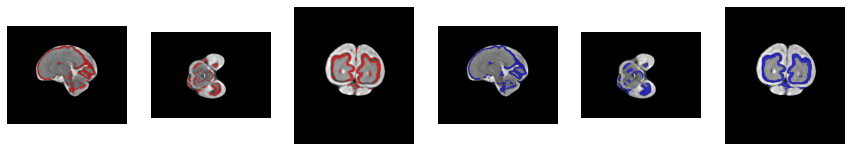

8	 Subject: marsFet044_33


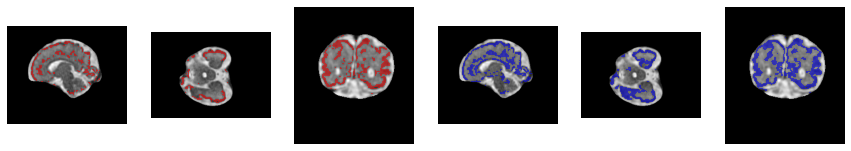

9	 Subject: marsFet253_28


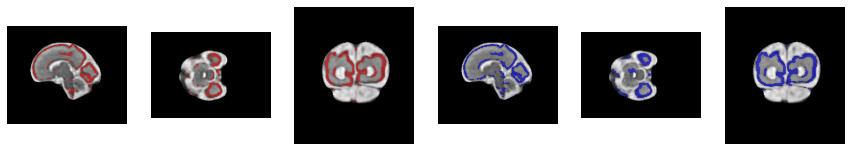

10	 Subject: marsFet001_33


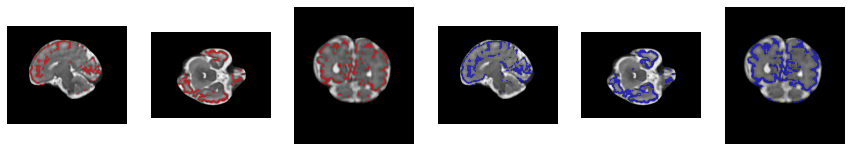

11	 Subject: marsFet039_34


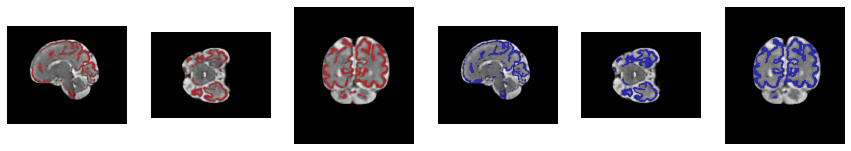

12	 Subject: marsFet036_34


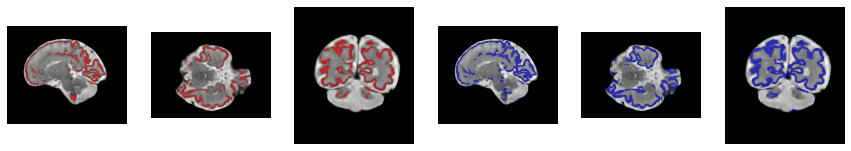

13	 Subject: marsFet029_32


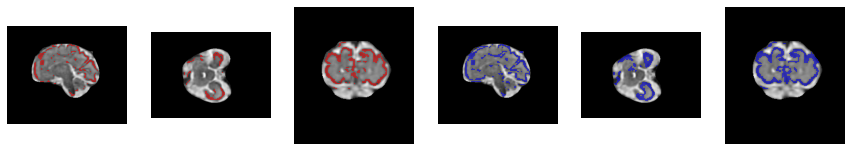

14	 Subject: marsFet043_29


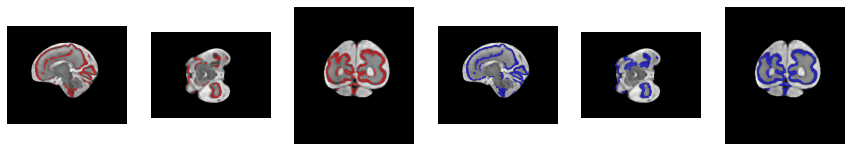

15	 Subject: marsFet004_33


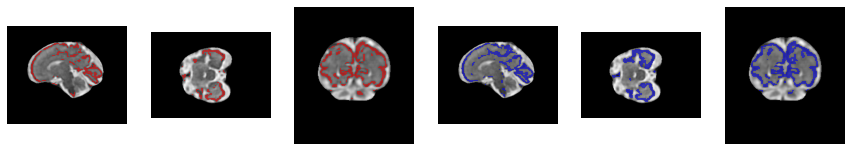

16	 Subject: marsFet020_30


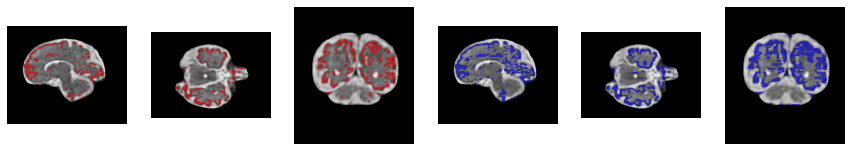

17	 Subject: marsFet016_33


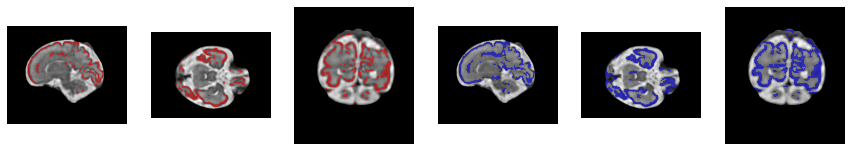

18	 Subject: marsFet009_32


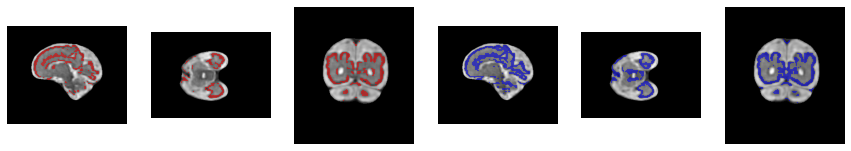

19	 Subject: marsFet260_29


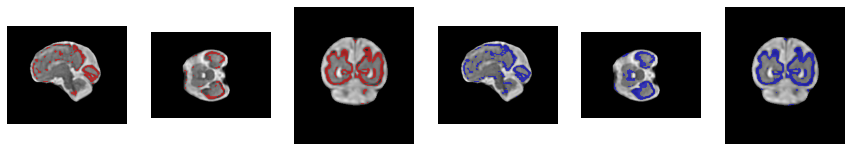

20	 Subject: marsFet235_33


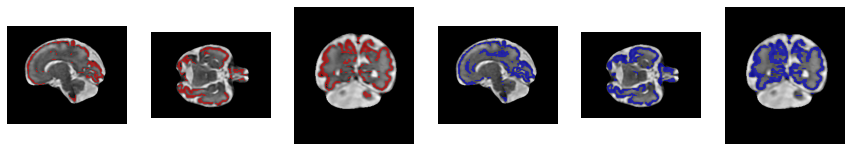

21	 Subject: marsFet027_28


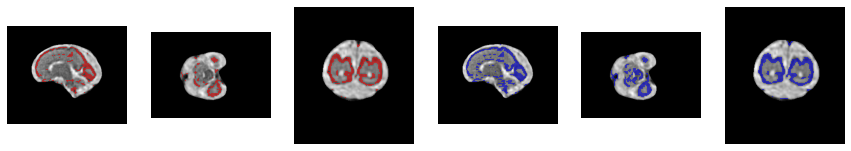

22	 Subject: marsFet045_30


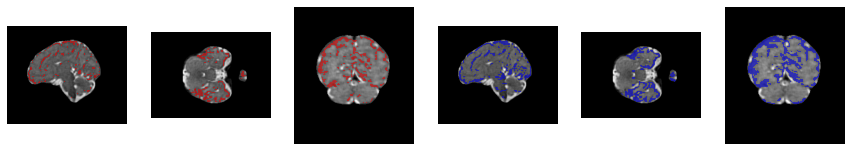

23	 Subject: marsFet007_29


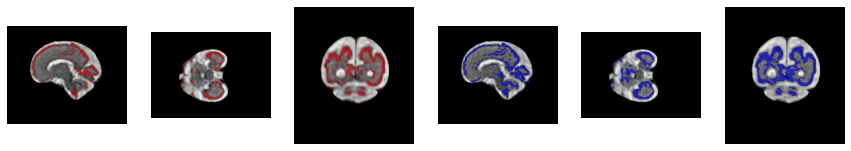

24	 Subject: marsFet019_34


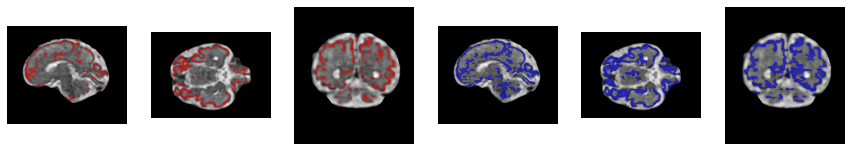

25	 Subject: marsFet040_36


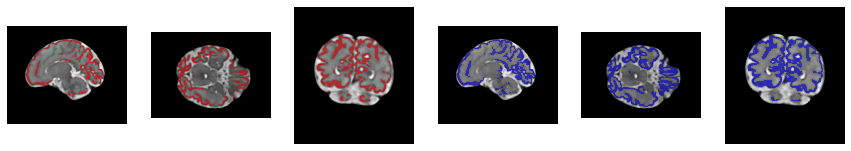

26	 Subject: marsFet092_28


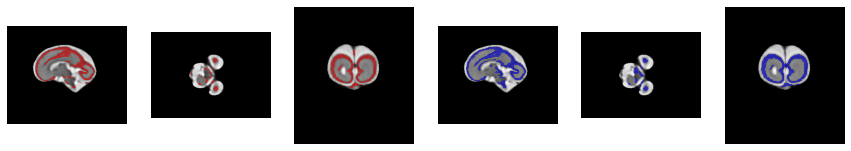

27	 Subject: marsFet049_31


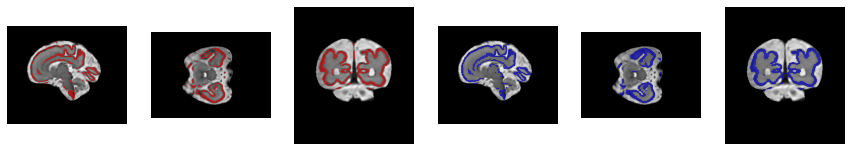

In [ ]:
fetus_imgs = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/fetus_dataset/img_fetus_norm_3D/'
fetus_3D_mask_pytorch = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_UNet_DA/output_b32_CP_fetus_3D/'
fetus_3D_mask_fetalcpseg = '/content/gdrive/My Drive/DL_fetus_tests/data_brain/results_2DFetalCPSeg/NoDeepSup/fetus_test_3D/'

ids_fetus = [splitext(splitext(file)[0])[0] for file in listdir(fetus_3D_mask_pytorch) if not file.startswith('.')]
#ids_dHCP.remove('GT')
num = 0
print(ids_fetus)

for idx in ids_fetus:
    num += 1

    print(str(num)+'\t Subject: '+str(idx))

    img_file = glob(fetus_imgs + idx + '.nii.gz')[0]
    pred_file_pytorch = glob(fetus_3D_mask_pytorch + idx + '.nii.gz')[0]
    pred_file_fetalcpseg = glob(fetus_3D_mask_fetalcpseg + idx + '.nii.gz')[0]
    
    #print(img_file)
    #print(pred_file_att)
    img = nib.load(img_file).get_fdata()
    pred_pytorch = nib.load(pred_file_pytorch).get_fdata()
    pred_fetalcpseg = nib.load(pred_file_fetalcpseg).get_fdata()

    # dHCP image
    img_all = preprocess(img, np.nanmin(img))
    img_all_ = img_all.copy().astype('float')
    img_all_[img_all_ == 0] = np.nan

    imgx100x = np.flip(img_all_[:,100,:])
    img100xx = img_all_[100,:,:]
    imgxx100 = img_all_[:,:,100]

    # Pytorch UNet
    pred_pytorch_all = preprocess(pred_pytorch, 0)
    pred_pytorch_all_ = pred_pytorch_all.copy().astype('float')
    pred_pytorch_all_[pred_pytorch_all_ == 0] = np.nan

    pred_pytorchx100x = np.flip(pred_pytorch_all_[:,100,:])
    pred_pytorch100xx = pred_pytorch_all_[100,:,:]
    pred_pytorchxx100 = pred_pytorch_all_[:,:,100]

    # FetalCPSeg
    pred_fetalcpseg_all = preprocess(pred_fetalcpseg, 0)
    pred_fetalcpseg_all_ = pred_fetalcpseg_all.copy().astype('float')
    pred_fetalcpseg_all_[pred_fetalcpseg_all_ == 0] = np.nan

    pred_fetalcpsegx100x = np.flip(pred_fetalcpseg_all_[:,100,:])
    pred_fetalcpseg100xx = pred_fetalcpseg_all_[100,:,:]
    pred_fetalcpsegxx100 = pred_fetalcpseg_all_[:,:,100]

    plt.subplots(1, 6, figsize=(15,6))
    plt.title('Pytorch UNet')
    plt.subplot(161)
    plt.imshow(imgx100x, cmap='gray')
    plt.imshow(pred_pytorchx100x, alpha=0.5, cmap='autumn', interpolation='none')
    plt.axis('off')
    plt.subplot(162)
    plt.imshow(img100xx, cmap='gray')
    plt.imshow(pred_pytorch100xx, alpha=0.5, cmap='autumn', interpolation='none')
    plt.axis('off')
    plt.subplot(163)
    plt.imshow(np.flip(imgxx100, axis=0), cmap='gray')
    plt.imshow(np.flip(pred_pytorchxx100, axis=0), alpha=0.5, cmap='autumn', interpolation='none')
    plt.axis('off')
    plt.subplot(164)
    plt.imshow(imgx100x, cmap='gray')
    plt.imshow(pred_fetalcpsegx100x, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(165)
    plt.imshow(img100xx, cmap='gray')
    plt.imshow(pred_fetalcpseg100xx, alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.subplot(166)
    plt.imshow(np.flip(imgxx100, axis=0), cmap='gray')
    plt.imshow(np.flip(pred_fetalcpsegxx100, axis=0), alpha=0.5, cmap='winter', interpolation='none')
    plt.axis('off')
    plt.show()